<a href="https://colab.research.google.com/github/YeshwanthSadum/Machine-Learning/blob/main/NLP_Project_Sentiment_Analysis_of_movie_reviews_GloVe%2C_BERT%2C_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Sentiment Analysis of movie reviews**

Data set - Rotten Tomatoes Reviews Dataset - https://www.kaggle.com/datasets/mrbaloglu/rotten-tomatoes-reviews-dataset

Consists of two columns - reviews and labels(0 and 1).

Models:

1. BERT, 2 dense layers followed by sigmoid activation.
2. GLoVe + LSTM : LSTM is used with GloVe word embeddings. 
3. GloVe + GRU

In [ ]:
pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 4.3 MB/s 
     |████████████████████████████████| 462 kB 49.6 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
import pandas as pd

df = pd.read_csv("/content/data_rt.csv")
df.head(5)

FileNotFoundError: ignored

In [ ]:
import numpy as np

In [ ]:
df.groupby('labels').describe()

In [ ]:
df.isnull().sum()

Splitting data into train test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['reviews'],df['labels'])

In [ ]:
len(y_train)

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "This is a very good movie", 
    "The climax was okay"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.9207194 , -0.40204158, -0.3329436 , ..., -0.25333905,
        -0.6436804 ,  0.9090512 ],
       [-0.8332587 , -0.17263016,  0.41510022, ...,  0.18888985,
        -0.5539779 ,  0.8586857 ]], dtype=float32)>

Build model

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(64, activation='LeakyReLU', name="hiddenlayer1")(l)
l = tf.keras.layers.Dense(16, activation='LeakyReLU', name="hiddenlayer2")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, batch_size = 32, epochs=10)

Epoch 1/10
250/250 [==============================] - 85s 329ms/step - loss: 0.6764 - accuracy: 0.5813 - precision: 0.5835 - recall: 0.5762
Epoch 2/10
250/250 [==============================] - 83s 332ms/step - loss: 0.5956 - accuracy: 0.6768 - precision: 0.6841 - recall: 0.6605
Epoch 3/10
250/250 [==============================] - 83s 334ms/step - loss: 0.5657 - accuracy: 0.7117 - precision: 0.7222 - recall: 0.6907
Epoch 4/10
250/250 [==============================] - 82s 326ms/step - loss: 0.5362 - accuracy: 0.7296 - precision: 0.7376 - recall: 0.7151
Epoch 5/10
250/250 [==============================] - 86s 343ms/step - loss: 0.5225 - accuracy: 0.7406 - precision: 0.7532 - recall: 0.7179
Epoch 6/10
250/250 [==============================] - 86s 343ms/step - loss: 0.5178 - accuracy: 0.7482 - precision: 0.7579 - recall: 0.7316
Epoch 7/10
250/250 [==============================] - 82s 327ms/step - loss: 0.5114 - accuracy: 0.7514 - precision: 0.7670 - recall: 0.7241
Epoch 8/10
250/250 [

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
model.evaluate(X_test, y_test)

84/84 [==============================] - 27s 311ms/step - loss: 0.5526 - accuracy: 0.7179 - precision: 0.9014 - recall: 0.4841


[0.5525515675544739,
 0.717929482460022,
 0.9014084339141846,
 0.48411497473716736]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
y_predicted = np.where(y_predicted>0.5, 1,0)

In [ ]:
y_predicted

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[1274,   70],
       [ 682,  640]])

Text(33.0, 0.5, 'Truth')

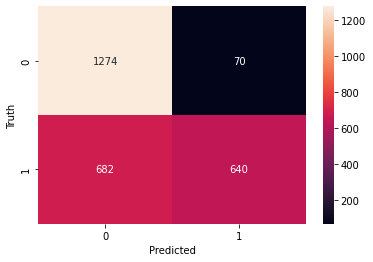

In [ ]:
#y_predicted = np.where(y_predicted > 0.5, 1, 0)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.65      0.95      0.77      1344
           1       0.90      0.48      0.63      1322

    accuracy                           0.72      2666
   macro avg       0.78      0.72      0.70      2666
weighted avg       0.78      0.72      0.70      2666



#LSTM + GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-04 19:58:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-04 19:58:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-04 19:58:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
import os

In [ ]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), ".keras/datasets/glove.6B.100d.txt"
)

import zipfile
zip_ref = zipfile.ZipFile('/content/glove.6B.zip', 'r')
zip_ref.extractall('/content/sample_data')
zip_ref.close()

embeddings_index = {}

with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
len(voc) + 2

1002

In [ ]:
X_test

42       the effort is sincere and the results are hone...
4800     davis the performer is plenty fetching enough ...
10229    symbolically , warm water under a red bridge i...
6371     although it's a bit smug and repetitive , this...
588      the inevitable double- and triple-crosses aris...
                               ...                        
8361     i like this movie a lot . i like that smith , ...
2132     scarlet diva has a voyeuristic tug , but all i...
8240     it's mildly entertaining , especially if you f...
7882     yes , it's as good as you remember . in fact ,...
9268     niccol the filmmaker merges his collaborators'...
Name: reviews, Length: 2666, dtype: object

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_test.values)
voc = encoder.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 994 words (6 misses)


In [ ]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable = True
    ),
    #tf.keras.layers.average(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='LeakyReLU'),
    tf.keras.layers.Dense(32, activation='LeakyReLU'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model2.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_13 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_79 (Embedding)    (None, None, 100)         100200    
                                                                 
 bidirectional_26 (Bidirecti  (None, 128)              84480     
 onal)                                                           
                                                                 
 dense_112 (Dense)           (None, 64)                8256      
                                                                 
 dense_113 (Dense)           (None, 32)                2080      
                                                                 
 dense_114 (Dense)           (None, 1)               

In [ ]:
history = model2.fit(X_train, y_train, batch_size = 32, epochs=50)

Epoch 1/50
250/250 [==============================] - 6s 10ms/step - loss: 0.6273 - accuracy: 0.6430 - precision: 0.6497 - recall: 0.6209
Epoch 2/50
250/250 [==============================] - 2s 10ms/step - loss: 0.5410 - accuracy: 0.7185 - precision: 0.7395 - recall: 0.6770
Epoch 3/50
250/250 [==============================] - 3s 11ms/step - loss: 0.4977 - accuracy: 0.7503 - precision: 0.7639 - recall: 0.7264
Epoch 4/50
250/250 [==============================] - 3s 12ms/step - loss: 0.4722 - accuracy: 0.7725 - precision: 0.7917 - recall: 0.7413
Epoch 5/50
250/250 [==============================] - 4s 16ms/step - loss: 0.4474 - accuracy: 0.7809 - precision: 0.8002 - recall: 0.7503
Epoch 6/50
250/250 [==============================] - 3s 12ms/step - loss: 0.4213 - accuracy: 0.8009 - precision: 0.8176 - recall: 0.7760
Epoch 7/50
250/250 [==============================] - 4s 15ms/step - loss: 0.3869 - accuracy: 0.8184 - precision: 0.8371 - recall: 0.7920
Epoch 8/50
250/250 [==============

In [ ]:
model2.evaluate(X_test, y_test)

84/84 [==============================] - 1s 6ms/step - loss: 3.4580 - accuracy: 0.7082 - precision: 0.7096 - recall: 0.6967


[3.4579641819000244, 0.7081770300865173, 0.7095531821250916, 0.696671724319458]

In [ ]:
y_predicted = model2.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_predicted)

Text(33.0, 0.5, 'Truth')

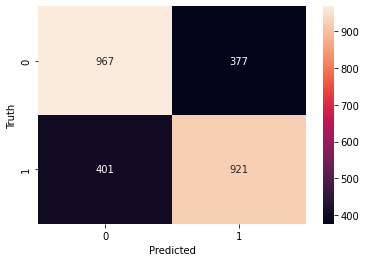

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1344
           1       0.71      0.70      0.70      1322

    accuracy                           0.71      2666
   macro avg       0.71      0.71      0.71      2666
weighted avg       0.71      0.71      0.71      2666



In [ ]:
model3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable = True
    ),
    #tf.keras.layers.average(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='LeakyReLU'),
    tf.keras.layers.Dense(32, activation='LeakyReLU'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
encoder('hello im yeshwanth').numpy()

array([  1, 604,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [ ]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
history = model3.fit(X_train, y_train, batch_size = 32, epochs=50)

Epoch 1/50
250/250 [==============================] - 32s 10ms/step - loss: 0.6509 - accuracy: 0.6322 - precision: 0.6411 - recall: 0.6005
Epoch 2/50
250/250 [==============================] - 2s 10ms/step - loss: 0.5543 - accuracy: 0.7156 - precision: 0.7345 - recall: 0.6777
Epoch 3/50
250/250 [==============================] - 2s 10ms/step - loss: 0.5124 - accuracy: 0.7379 - precision: 0.7572 - recall: 0.7024
Epoch 4/50
250/250 [==============================] - 2s 9ms/step - loss: 0.4780 - accuracy: 0.7613 - precision: 0.7820 - recall: 0.7264
Epoch 5/50
250/250 [==============================] - 2s 9ms/step - loss: 0.4447 - accuracy: 0.7803 - precision: 0.7990 - recall: 0.7506
Epoch 6/50
250/250 [==============================] - 2s 10ms/step - loss: 0.4070 - accuracy: 0.8012 - precision: 0.8169 - recall: 0.7778
Epoch 7/50
250/250 [==============================] - 2s 9ms/step - loss: 0.3806 - accuracy: 0.8229 - precision: 0.8438 - recall: 0.7937
Epoch 8/50
250/250 [================

In [ ]:
model3.evaluate(X_test, y_test)

84/84 [==============================] - 1s 6ms/step - loss: 3.1030 - accuracy: 0.7063 - precision: 0.7075 - recall: 0.6952


[3.102954149246216, 0.7063015699386597, 0.707467257976532, 0.695158839225769]

In [ ]:
y_predicted = model3.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_predicted)

Text(33.0, 0.5, 'Truth')

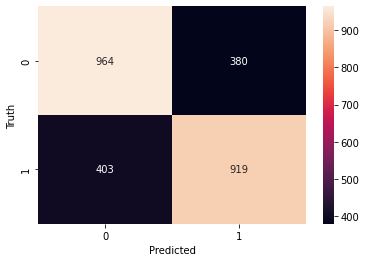

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1344
           1       0.71      0.70      0.70      1322

    accuracy                           0.71      2666
   macro avg       0.71      0.71      0.71      2666
weighted avg       0.71      0.71      0.71      2666

